In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.double)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from asymmetric_kde import ImproperGammaEstimator
import pandas as pd 

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [32]:
TARGET_SHAPE = "sphere" # chose from ["sphere", "nanorod"]
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]


In [33]:
traj = torch.load("./retrosynthesis/%s/optim_traj.pkl"%TARGET_SHAPE, map_location=torch.device('cpu'))
grid_comps = traj["grid_comps"]
grid_loss = traj["grid_loss"].detach().numpy()*10

target_x = traj["target_x"].squeeze()
target_y = traj["target_y"]

In [34]:
if TARGET_SHAPE=="sphere":
    RESTRAT_INDEX = 1
    expt = np.load("../misc/sphere_retrosynth_expt.npz")
else:
    RESTRAT_INDEX = 2
    expt = np.load("../misc/nanorod_retrosynth_expt.npz")
    
trajectory = traj["X_traj"][RESTRAT_INDEX,...]

In [35]:
def prettify_spectra(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Intensity (normalized)")
    
def min_max_scale(y):
    return (y-min(y))/(max(y)-min(y))

def unscale_wavelength(wl, limits=[400, 900]):
    return wl*(limits[1]-limits[0]) + limits[0]

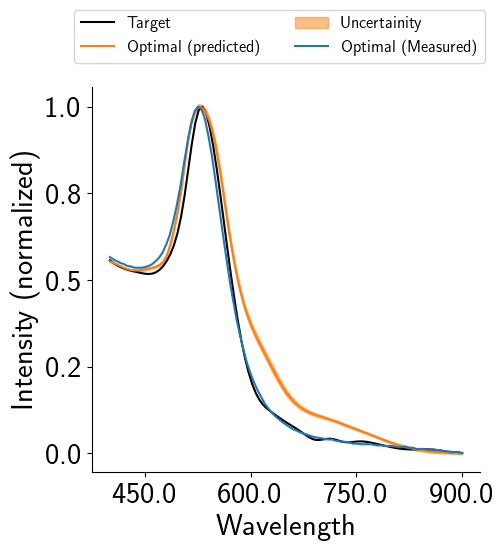

In [36]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(unscale_wavelength(target_x), 
            min_max_scale(target_y.squeeze().numpy()), 
            c="k", 
            label="Target"
            )
    optim_spectra = traj["spectra"][RESTRAT_INDEX,...]
    mu = min_max_scale(optim_spectra[:,0].numpy())
    sigma = optim_spectra[:,1].numpy()
    ax.plot(unscale_wavelength(target_x), 
            mu, 
            c="tab:orange", 
            label="Optimal (predicted)"
            )
    ax.fill_between(unscale_wavelength(target_x),
                    mu-sigma, 
                    mu+sigma, 
                    color='tab:orange',
                    alpha = 0.5,
                    label="Uncertainity"
                    )
    ax.plot(expt["wl"], min_max_scale(expt["I"]), label="Optimal (Measured)")
    prettify_spectra(ax)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, 
               loc='upper center', 
               bbox_to_anchor=[0.5,1.05], prop={'size': 12}
               )
    plt.savefig("./figures/target_pred_comparision_%s.png"%TARGET_SHAPE)
    plt.show()

In [37]:
def prettify_axis(ax):
    ax.set_xlabel(r"Silver Nitrate ($10^{-4}$ M)")
    ax.set_ylabel(r"Ascorbic Acid ($10^{-3}$ M)")
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))

    SN_labels = [item.get_text() for item in ax.get_xticklabels()]
    SN_vol_to_conc = lambda v : (6.4*v)/(300)
    SN_conc_labels = []
    for l in SN_labels:
        SN_conc_labels.append("%.2f"%SN_vol_to_conc(float(l)))
    ax.set_xticklabels(SN_conc_labels)

    AA_labels = [item.get_text() for item in ax.get_yticklabels()]
    AA_vol_to_conc = lambda v : (6.3*v)/(300)
    AA_conc_labels = []
    for l in AA_labels:
        AA_conc_labels.append("%.2f"%AA_vol_to_conc(float(l)))
    ax.set_yticklabels(AA_conc_labels)

    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1504/951585302.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(SN_conc_labels)
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1504/951585302.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(AA_conc_labels)


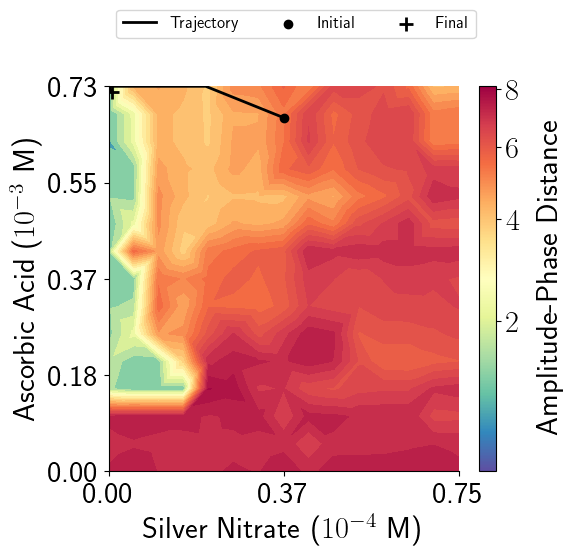

In [38]:
from matplotlib.colors import PowerNorm

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    norm = PowerNorm(gamma=0.5)
    cmap = 'Spectral_r'
    contour = ax.tricontourf(grid_comps[:,0],
                         grid_comps[:,1],
                         grid_loss,
                         levels=25,
                         cmap=cmap,
                         norm = norm,
                         )

    ax.plot(trajectory[:,0], trajectory[:,1],lw=2,c='k', label="Trajectory")
    ax.scatter(trajectory[0,0], trajectory[0,1],s=100,c='k',marker='.',zorder=10,lw=2, label="Initial")
    ax.scatter(trajectory[-1,0], trajectory[-1,1],s=100,c='k',marker='+',zorder=10,lw=2, label="Final")
    prettify_axis(ax)

    mappable = ScalarMappable(norm=norm, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(mappable,shrink=0.5, aspect=5, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Amplitude-Phase Distance', labelpad=12)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncols=3,
               loc='upper center', 
               bbox_to_anchor=[0.5,1.05], prop={'size': 12}
               )
    plt.savefig("./figures/optimization_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()

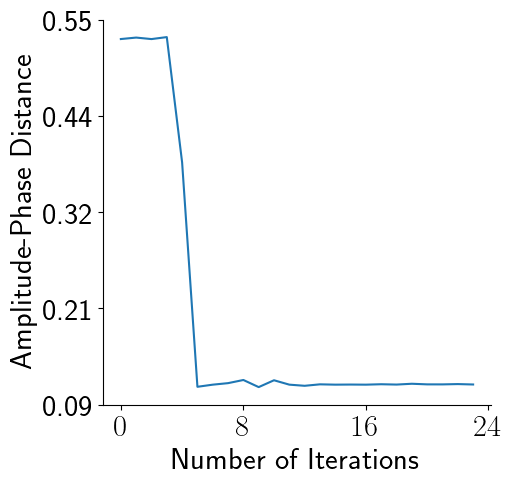

In [39]:
loss_traj = traj["loss"][RESTRAT_INDEX,...]
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(np.arange(loss_traj.shape[0]), loss_traj)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,integer=True))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Amplitude-Phase Distance")
    plt.savefig("./figures/lossfunc_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()

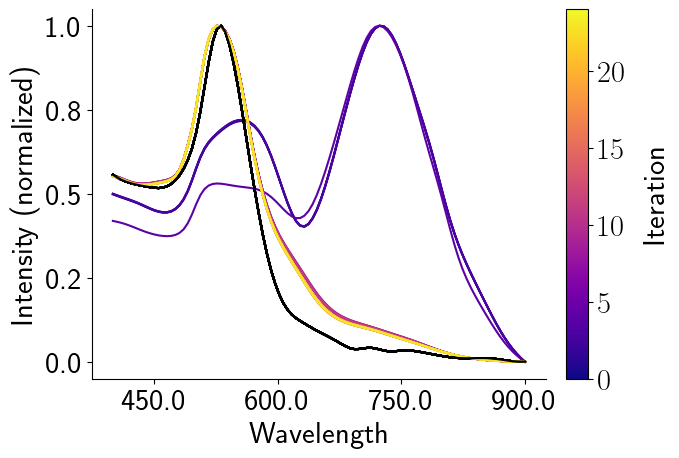

In [40]:
spectra_traj = traj["spectra_traj"][RESTRAT_INDEX,...]
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("plasma")
    norm = Normalize(vmin=0, vmax = spectra_traj.shape[0])
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    for i in range(spectra_traj.shape[0]):
        ax.plot(unscale_wavelength(target_x), 
                min_max_scale(spectra_traj[i,:,0].numpy()), 
                color=cmap(norm(i))
                )
        ax.plot(unscale_wavelength(target_x), 
                min_max_scale(target_y.squeeze().numpy()), 
                c="k", label="Target"
                )
    prettify_spectra(ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label='Iteration', labelpad=12)
    plt.savefig("./figures/spectra_trajectory_%s.png"%TARGET_SHAPE)
    plt.show()

### Plot TEM stats

In [41]:
sphere_target_TEM = "../TEM/250201_AuNP_Kiran_Huat/A1_0/Results.csv"
rod_target_TEM = "../TEM/250201_AuNP_Kiran_Huat/A2_1/Results.csv"

In [42]:
if TARGET_SHAPE=="sphere":
    stats = pd.read_csv(sphere_target_TEM)
else:
    stats = pd.read_csv(rod_target_TEM)
measurements = stats["Length"].to_numpy().reshape(int(len(stats)/2), 2)
aspect_ratios = measurements[:,0]/measurements[:,1]

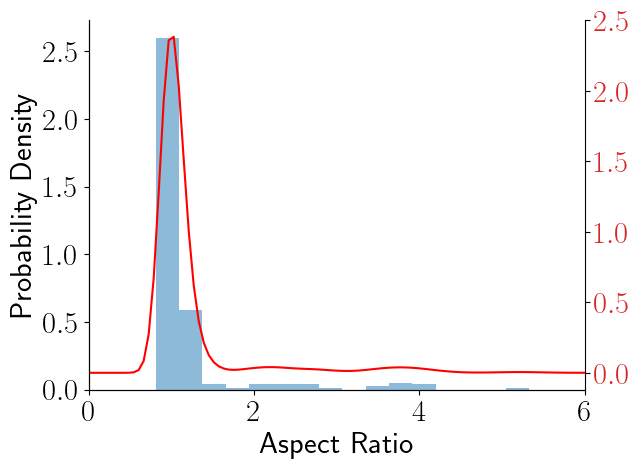

In [43]:
kde = ImproperGammaEstimator(aspect_ratios, 'plugin')
limits = [0.0, 6.0]
x_range = np.linspace(limits[0], limits[1], 100)
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    ax.hist(aspect_ratios, 
            bins=30, 
            density=True, 
            alpha=0.5, 
            )
    ax.set_ylabel("Probability Density")
    ax2 = ax.twinx()
    ax2.plot(x_range, kde(x_range), color='red', label='KDE')
    ax.set_xlim(limits)
    ax.spines['right'].set_visible(True)
    ax.set_xlabel("Aspect Ratio")
    ax2.tick_params(axis='y', labelcolor="tab:red")
    plt.savefig("./figures/tem_aspect_ratios_%s.png"%TARGET_SHAPE)
    plt.show()